# ============================================================
# FPCA-Based Clustering of Urban Morphology Trajectories
## Mecklenburg County (1990–2023)
# ============================================================

### Objective
This analysis extends the univariate trend diagnostics by **grouping the
temporal trajectories of multiple urban form indicators into a small
number of representative trend archetypes**.

Each indicator is treated as a **functional object** (a smooth curve over time).
Functional Principal Component Analysis (FPCA) is used to extract dominant
modes of temporal variation, and indicators are then clustered based on their
FPCA scores.

This allows us to:
- Reduce dimensionality (10–11 indicators → 2–4 latent trend dimensions)
- Identify groups of indicators with **similar long-term evolution**
- Produce generalized trend categories for interpretation and synthesis


# ============================================================
# Data Preparation
# ============================================================

Clustering trajectories requires that all indicators:
- Are defined on a common time grid
- Are summarized consistently (median in this case)
- Are comparable in scale (standardization)

In [27]:
# ============================================================
# FPCA (Functional PCA) + Clustering of Measure Trajectories
# Mecklenburg County (1990–2023)
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
# -----------------------------
# 0) Load data
# -----------------------------
ABT = gpd.read_file(
    "../../../../Data/Final_dataset/ABT/ABT.gpkg",
    layer="subdivisions"
)

ABT = ABT[(ABT["year"] >= 1990) & (ABT["year"] <= 2023)].copy()
years = np.arange(1990, 2024)

In [53]:
# -----------------------------
# 1) Choose measures + summary series type
# -----------------------------
measures = [
    'HAC_dist', 'BAD', 'SHD', 'int_den025', 'nd_deg025', 'int_den05', 'nd_deg05', 'int_den075', 'nd_deg075', 'int_den1', 'nd_deg1'
]

SUMMARY = "median"   # "mean" or "median" (median is usually safer)
SMOOTHER = "spline"  # "spline" (recommended) or "lowess_like"

In [54]:
# -----------------------------
# 2) Build annual series for all measures
# -----------------------------
def build_annual_series(df: gpd.GeoDataFrame, measures, summary="median") -> pd.DataFrame:
    if summary == "mean":
        out = df.groupby("year")[measures].mean()
    elif summary == "median":
        out = df.groupby("year")[measures].median()
    else:
        raise ValueError("summary must be 'mean' or 'median'")

    out = out.reindex(years)  # ensure full year index
    return out

annual = build_annual_series(ABT, measures, summary=SUMMARY)

# ============================================================
# Functional Representation (Smoothing)
# ============================================================

### Why smoothing?
FPCA assumes each indicator is an underlying **smooth temporal process** observed with noise.  
We therefore smooth each annual indicator series using **cubic smoothing splines**, evaluated on a common annual grid (1990–2023).

### What FPCA does here
FPCA decomposes the set of indicator trajectories into a small number of orthogonal **temporal modes of variation**:

- **FPC1** usually captures the dominant long-run evolution (e.g., monotonic increase/decrease).
- **FPC2** often captures secondary differences such as timing shifts, acceleration, or curvature.

Each indicator is represented by its **FPC scores**, which summarize the full trajectory in a low-dimensional space.

In [60]:
# -----------------------------
# 3) Smooth each measure curve (functional representation)
#    Then evaluate on common grid (years)
# -----------------------------
def smooth_curve_spline(x_years, y, s=None, k=3):
    """
    Fit a smoothing spline.
    - s controls smoothness: larger => smoother. If s=None, scipy chooses based on data size.
    - k is spline degree (3 = cubic).
    """
    x_years = np.asarray(x_years, dtype=float)
    y = np.asarray(y, dtype=float)

    mask = np.isfinite(y)
    x = x_years[mask]
    y2 = y[mask]

    # Need enough points for cubic spline
    if len(x) < (k + 1):
        return np.full_like(x_years, np.nan, dtype=float)

    # If s is None, UnivariateSpline will pick a default that interpolates-ish
    spline = UnivariateSpline(x, y2, s=s, k=k)
    return spline(x_years)

# You can tune smoothness. A decent default:
# - If you want more smoothing, increase s (e.g., s=0.5*len(years), 1.0*len(years), etc.)
SPLINE_S = 0.5 * len(years)

trend = pd.DataFrame(index=years, columns=measures, dtype=float)
for m in measures:
    trend[m] = smooth_curve_spline(years, annual[m].values, s=SPLINE_S, k=3)

# Drop years with any NaN across measures (ensures all curves comparable)
trend = trend.dropna(axis=0, how="any")

In [61]:
# -----------------------------
# 4) Standardize each curve (shape-based clustering)
#    This is important: avoids units dominating FPCA.
# -----------------------------
trend_z = (trend - trend.mean(axis=0)) / trend.std(axis=0, ddof=0)
trend_z = trend_z.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

# Each "function" is a vector across years.
# For FPCA: observations = measures, features = time points.
X = trend_z.T.values  # shape = (n_measures, n_years)

print("FPCA input matrix shape (measures x years):", X.shape)

FPCA input matrix shape (measures x years): (11, 34)


In [62]:
# -----------------------------
# 5) FPCA via PCA on discretized curves
# -----------------------------
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS, random_state=0)
scores = pca.fit_transform(X)  # (n_measures, n_components)

expl = pca.explained_variance_ratio_
print("Explained variance ratio:", np.round(expl, 3), " | cumulative:", np.round(expl.cumsum(), 3))

scores_df = pd.DataFrame(scores, index=trend_z.columns, columns=[f"FPC{i+1}" for i in range(N_COMPONENTS)])

Explained variance ratio: [0.797 0.182]  | cumulative: [0.797 0.98 ]


### FPCA component selection
We retain **2 functional components** because they explain nearly all temporal variation across indicators:

- **FPC1:** ~80% of variance  
- **FPC2:** ~18% of variance  
- **Cumulative (FPC1–FPC2):** ~98%


# ============================================================
# Clustering Indicator Trajectories (Trajectory Archetypes)
# ============================================================

### Rationale
Indicators are clustered based on their **FPCA scores**, which summarize their entire temporal evolution in a low-dimensional space.

### Choosing the number of clusters (K)
We evaluate **K = 2…6** using the **silhouette score** and select a small, interpretable K (typically 3–5) that balances:
- separation between clusters,
- stability of membership,
- substantive interpretability.

The output is a set of **trajectory archetypes** (cluster mean curves), and each indicator is assigned to one archetype.


In [63]:
# -----------------------------
# 6) Choose K (clusters) using silhouette on FPCA scores
# -----------------------------
def pick_k_by_silhouette(scores, k_min=2, k_max=6):
    best_k = None
    best_score = -1
    all_scores = {}

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=100, random_state=0)
        labels = km.fit_predict(scores)
        s = silhouette_score(scores, labels)
        all_scores[k] = s
        if s > best_score:
            best_score = s
            best_k = k

    return best_k, all_scores

best_k, sil = pick_k_by_silhouette(scores, 2, min(6, len(scores_df)-1))
print("Silhouette scores:", {k: round(v, 3) for k, v in sil.items()})
print("Best K:", best_k)

K = 2  # set K manually OR use best_k
km = KMeans(n_clusters=K, n_init=200, random_state=0)
labels = km.fit_predict(scores)

print(f"\nSelected K:{K}")

cluster_map = pd.Series(labels, index=scores_df.index, name="cluster").sort_values()
print("\nCluster assignment:")
print(cluster_map)

Silhouette scores: {2: 0.756, 3: 0.588, 4: 0.525, 5: 0.426, 6: 0.536}
Best K: 2

Selected K:2

Cluster assignment:
BAD           0
SHD           0
int_den025    0
nd_deg025     0
int_den05     0
nd_deg05      0
int_den075    0
nd_deg075     0
int_den1      0
nd_deg1       0
HAC_dist      1
Name: cluster, dtype: int32


# ============================================================
# Visualization of Trajectory Clusters
# ============================================================

### Interpretation
Each plot shows:
- Thin lines: standardized smoothed trajectories of indicators in the cluster
- Thick line: cluster-average trajectory (generalized trend)

These clusters represent **reduced, interpretable categories of temporal
urban morphology evolution**.


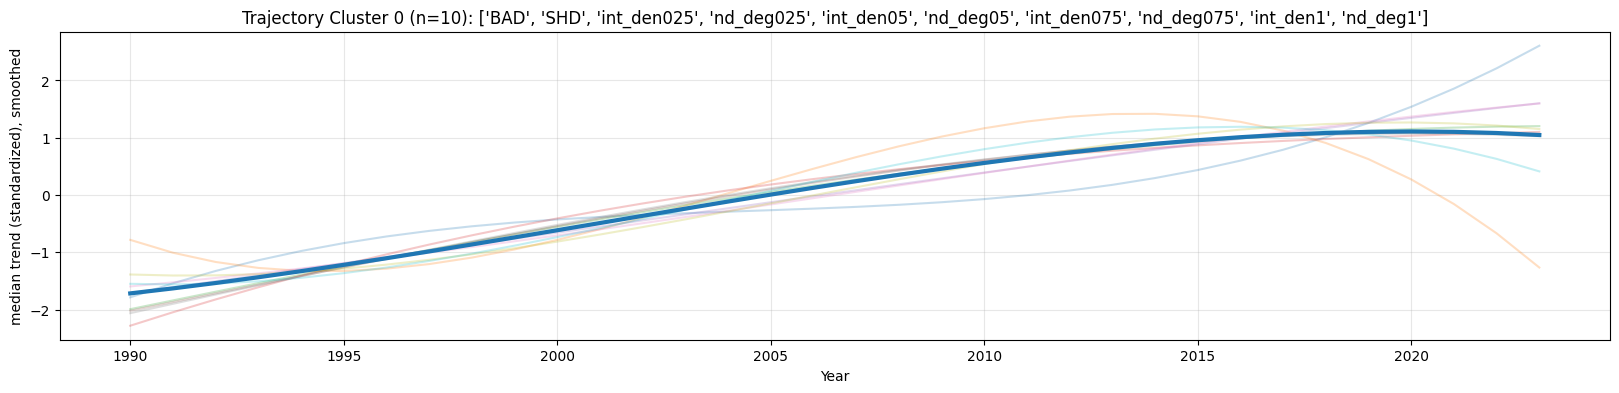

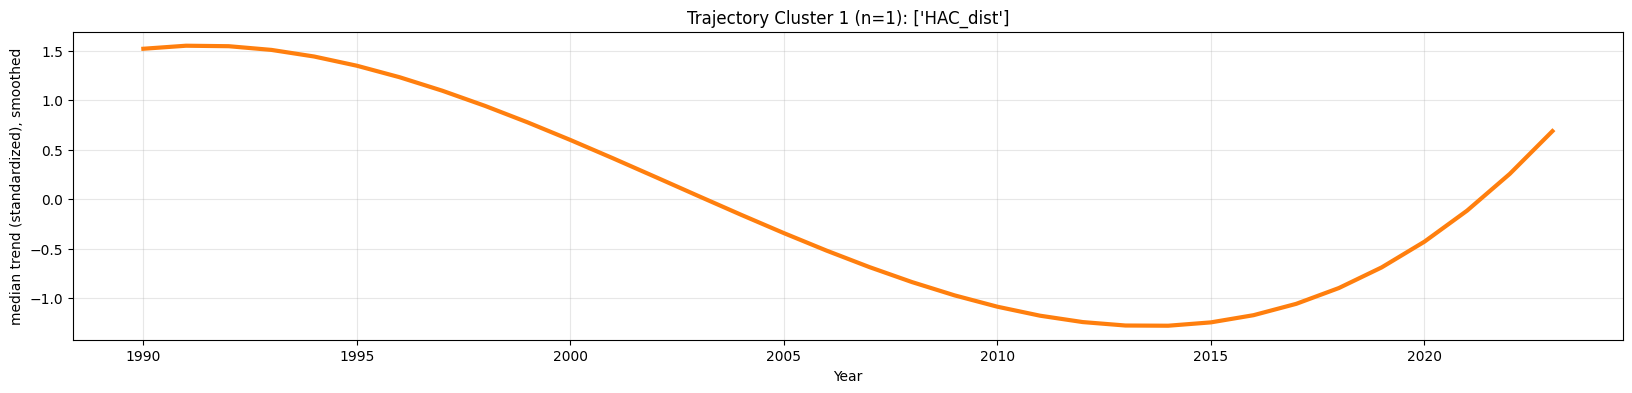

In [64]:
# -----------------------------
# 7) Visualization A: cluster mean trajectories + members
# -----------------------------
for c in sorted(cluster_map.unique()):
    members = cluster_map[cluster_map == c].index.tolist()
    plt.figure(figsize=(20, 4))
    for m in members:
        plt.plot(trend_z.index, trend_z[m], alpha=0.25)
    plt.plot(trend_z.index, trend_z[members].mean(axis=1), linewidth=3)
    plt.title(f"Trajectory Cluster {c} (n={len(members)}): {members}")
    plt.xlabel("Year")
    plt.ylabel(f"{SUMMARY} trend (standardized), smoothed")
    plt.grid(alpha=0.3)
    plt.show()

In [65]:
!jupyter nbconvert --to html --no-input time_series_bivariate.ipynb --output ../../../../output/Notebook_Outputs/time_series/multivariate_analysis.html

[NbConvertApp] Converting notebook time_series_bivariate.ipynb to html
[NbConvertApp] Writing 747244 bytes to ..\..\..\..\output\Notebook_Outputs\time_series\multivariate_analysis.html
